In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,UpSampling2D,Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
import numpy as np

import os
import random
import pickle
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(os.listdir("/content/gdrive/My Drive/covid-chestxray-dataset-master/covid-chestxray-dataset-master/data"))

['covid', 'non_covid']


In [0]:
IMG_SIZE = 128

In [0]:
CATEGORIES = ['covid', 'non_covid']
dataset = []

def generate_data():
    for category in CATEGORIES:
        path = f'/content/gdrive/My Drive/covid-chestxray-dataset-master/covid-chestxray-dataset-master/data/{category}'
        class_id = CATEGORIES.index(category)
        for image in os.listdir(path):
            try:
                image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_COLOR)
                image_array = cv2.resize(image_array, (IMG_SIZE,IMG_SIZE))
                dataset.append([image_array, class_id])
            except Exception as e:
                print(e)
    random.shuffle(dataset)
                
generate_data()

In [0]:
print(len(dataset))

162


In [0]:
data = []
labels = []
for features, label in dataset:
    data.append(features)
    labels.append(label)

In [0]:
import tensorflow as tf
data = np.array(data)
data.reshape(-1,128,3)

array([[[193, 193, 193],
        [190, 190, 190],
        [185, 185, 185],
        ...,
        [174, 174, 174],
        [173, 173, 173],
        [173, 173, 173]],

       [[183, 183, 183],
        [150, 150, 150],
        [117, 117, 117],
        ...,
        [117, 117, 117],
        [111, 111, 111],
        [110, 110, 110]],

       [[136, 136, 136],
        [111, 111, 111],
        [ 85,  85,  85],
        ...,
        [ 79,  79,  79],
        [ 74,  74,  74],
        [ 69,  69,  69]],

       ...,

       [[201, 201, 201],
        [200, 200, 200],
        [201, 201, 201],
        ...,
        [200, 200, 200],
        [195, 195, 195],
        [191, 191, 191]],

       [[205, 205, 205],
        [200, 200, 200],
        [204, 204, 204],
        ...,
        [199, 199, 199],
        [192, 192, 192],
        [183, 183, 183]],

       [[209, 209, 209],
        [201, 201, 201],
        [205, 205, 205],
        ...,
        [198, 198, 198],
        [186, 186, 186],
        [188, 188, 188]]

In [0]:
from sklearn.model_selection import train_test_split
data = data/255
train_x,data,train_y,labels =train_test_split(data,labels,test_size=0.2)
test_data, validation_data, test_labels, validation_labels = train_test_split(data, 
                                                                    labels,
                                                                   test_size=0.7)

In [0]:
datagen_train = ImageDataGenerator(rescale=1./255,
                            rotation_range=45,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

datagen_test = ImageDataGenerator(rescale=1./255)
datagen_validation = ImageDataGenerator(rescale=1./255)

In [0]:
datagen_train.fit(train_x)
datagen_test.fit(test_data)
datagen_test.fit(validation_data)

In [0]:
input_layer=Input(shape= (128,128,3))

In [0]:
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
encoder2 = MaxPooling2D((2, 2), padding='same')(encoder2)
encoder3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder2)
encoder3 = MaxPooling2D((2, 2), padding='same')(encoder3)


In [0]:
# decoder
decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder3)
decoder = UpSampling2D((2, 2))(decoder)
decoder2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
decoder2 = UpSampling2D((2, 2))(decoder2)
decoder3 = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder2)
decoder3 = UpSampling2D((2, 2))(decoder3)
#output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder3)
decoder4 = Dense(256, activation='relu')(decoder3)
output_l=Flatten()(decoder4)


In [0]:
output_layer = Dense(2)(output_l)



ae = Model(input_layer, output_layer)
ae.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0   

In [0]:
ae.compile(optimizer='adam', loss='mse',metrics=['accuracy'])


batch_size = 16
epochs = 40

#early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1, mode='auto')
history = ae.fit(train_x, train_x, batch_size=batch_size,epochs=epochs,validation_split=0.2)

Epoch 1/40


ValueError: ignored

In [0]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')


Training Accuracy: 0.8349331021308899
Training Loss: 0.004793606232851744
Validation Accuracy: 0.913010835647583
Validation Loss: 0.0058923037722706795


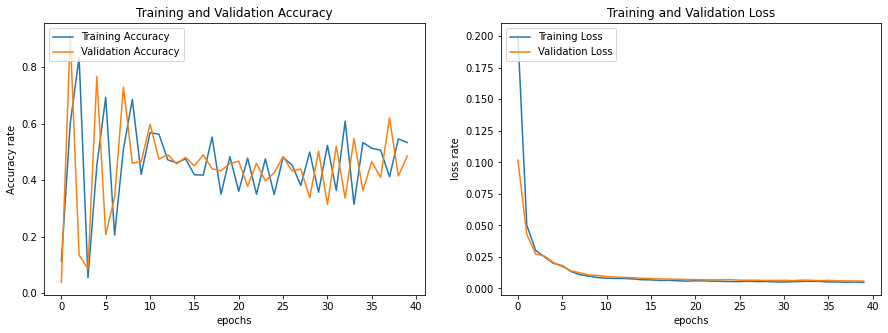

In [0]:
epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.xlabel('epochs')
plt.ylabel('Accuracy rate')
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.legend(loc="upper left")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.xlabel('epochs')
plt.ylabel('loss rate')
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper left")
plt.title("Training and Validation Loss")
plt.show()

In [0]:
class_names = ['cancer', 'normal']
def plot_images(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i],images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img)
    
    predicted_label = np.argmax(predictions_array)
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label]))

In [0]:
pred=ae.predict( test_data).argmax( axis=-1 ) 
print(len(pred))
pred.resize(9,1)
print ( pred )

9
[[1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]]


In [0]:
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
print(test_labels,pred)
print('F1_score : ',f1_score(test_labels,pred,average='micro'))
print('sensitibity : ',metrics.recall_score(test_labels, pred,average='micro'))

[1, 0, 0, 0, 0, 0, 1, 0, 0] [[1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]]
F1_score :  0.1111111111111111
sensitibity :  0.1111111111111111


In [0]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show() 

In [0]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.25      0.50      0.33         2
           2       0.00      0.00      0.00         0

    accuracy                           0.11         9
   macro avg       0.08      0.17      0.11         9
weighted avg       0.06      0.11      0.07         9



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


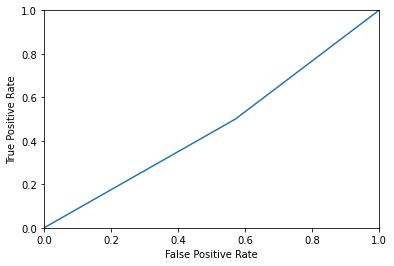

0.4642857142857143
0.02988071523335984


In [0]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

fpr , tpr , thresholds = roc_curve (test_labels,pred)
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(test_labels,pred) 
print(auc_score) 
print(matthews_corrcoef(test_labels,pred))